<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.layers import TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Sequential
from tensorflow.keras.utils import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import gradio as gr

### Datos

El dataset seleccionado es un libro en ingles llamado "Odyssey of the Dragonlords". Este libro es una aventura prediseñada para Dungeons Masters y la version 5.0 de Dungeons & Dragons. El documento original está en formato .pdf y se utilizaron herramientas online para transformarlo a .txt.

A grandes rasgos, este libro desarrolla el camino que emprende un grupo de aventureros en un entorno similar a la mitologia griega (con dioses e historia específicos del setting del libro) para salvar a su mundo de la perdición, y cómo ellos logran ascender a la divinidad en el proceso.

Por cuestiones de tiempos de entrenamiento y para facilitar probar distintos tipos de modelo, se redujo a la introduccion (20 paginas) de este libro.

In [2]:
with open("Odyssey of the Dragonlords - char.txt", "r") as file:
    lines = file.readlines()
    article_text = "".join(line.strip() for line in lines)

# en article text se encuentra el texto de todo el libro
article_text = article_text.lower()

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [3]:
# seleccionamos el tamaño de contexto
max_context_size = 100

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)
vocab_size = len(chars_vocab)

# la longitud de vocabulario de caracteres es:
print(f"Vocabulario: {vocab_size} letras")

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

Vocabulario: 36 letras


###  Tokenizar

In [4]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]
len(tokenized_text)

29315

### Organizando y estructurando el dataset

In [5]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [6]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [7]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [8]:
print(X.shape)
print(X[0,:10])
print(y[0,:10])

(26215, 100)
[ 5 12 14 28  6 13 12 34 19  6]
[12 14 28  6 13 12 34 19  6 34]


## Definiendo los modelos

### Definir el modelo con RNN

In [16]:
model_RNN = Sequential()
model_RNN.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_RNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_RNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_RNN.add(Dense(vocab_size, activation='softmax'))
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_RNN.summary()

c:\Users\Nicolas\anaconda3\envs\dataAnalysis\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 36)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        47,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 200)      │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 36)       │         7,236 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,836 (526.70 KB)

 Trainable params: 134,836 (526.70 KB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [9]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5, nn_type='RNN'):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data
      self.target = []
      self.padded = []
      self.nn_type = nn_type

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl[self.nn_type].append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"my_model{self.nn_type}.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Definir el modelo con GRU

Creamos el modelo con neuronas tipo GRU (Gated recurrent units). Este tipo de unidad ayuda a solucionar el problema de vanishing gradient (cuando los gradientes de los pesos de la red se vuelven muy pequeños, lo que dificulta el aprendizaje).

Las unidades GRU son una simplificacion de las LSTM, ya que utilizan una sola compuerta para controlar el flujo de informacion hacia la celda de memoria. Este tipo de unidad es mas efectiva cuando se requiere que la red aprenda rapido.

In [17]:
model_GRU = Sequential()
model_GRU.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_GRU.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_GRU.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_GRU.add(Dense(vocab_size, activation='softmax'))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_GRU.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 36)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 200)      │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 200)      │       241,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 36)       │         7,236 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,236 (1.49 MB)

 Trainable params: 391,236 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

### Definir el modelo con LSTM

Creamos el modelo con neuronas tipo LSTM (long short term memory). Al igual que las GRU, este tipo de unidad ayuda con el problema de vanishing gradient. Pero lo hace por medio de tres compuertas en vez de una: input, output y forget.

Este tipo de unidad es efectiva para tareas mas complejas y que requieran memoria a largo plazo.

In [18]:
model_LSTM = Sequential()
model_LSTM.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_LSTM.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_LSTM.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_LSTM.add(Dense(vocab_size, activation='softmax'))
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 36)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       189,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 200)      │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 36)       │         7,236 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,636 (1.97 MB)

 Trainable params: 517,636 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [19]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = {
    "RNN": [],
    "GRU": [],
    "LSTM": []
}
hist = model_RNN.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl["RNN"], nn_type='RNN')], batch_size=256)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.8714
 mean perplexity: 9.533387161312813 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 2.8686
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.1990
 mean perplexity: 8.802680182175846 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - loss: 2.1986
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.0510
 mean perplexity: 8.29821406215687 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - loss: 2.0507
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 1.9266
 mean perplexity: 8.549950778232688 

103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 1.9263
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.8243
 mean perplexity: 7.822582473687018 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 1.8240
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 1.7360
 mean perplexity: 8.06592683940546

In [20]:
hist = model_GRU.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl["GRU"], nn_type='GRU')], batch_size=256)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 2.9951
 mean perplexity: 11.201584645138908 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 48s 428ms/step - loss: 2.9933
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 2.4283
 mean perplexity: 9.736111554759828 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - loss: 2.4278
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 2.2937
 mean perplexity: 9.248917425699773 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - loss: 2.2935
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 2.2061
 mean perplexity: 8.775617562594212 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 2.2059
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 2.1123
 mean perplexity: 8.421453913399104 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 2.1121
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 2.0103
 mean perplexit

In [21]:
hist = model_LSTM.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl["LSTM"], nn_type='LSTM')], batch_size=256)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.0491
 mean perplexity: 17.21611817692677 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 56s 505ms/step - loss: 3.0482
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 2.9072
 mean perplexity: 16.281178545962025 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 49s 477ms/step - loss: 2.9071
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 2.7999
 mean perplexity: 12.372885865198068 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 49s 478ms/step - loss: 2.7992
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 2.5304
 mean perplexity: 10.588292766966564 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 49s 475ms/step - loss: 2.5301
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 2.4099
 mean perplexity: 10.173585654686983 

Saved new model!
103/103 ━━━━━━━━━━━━━━━━━━━━ 49s 476ms/step - loss: 2.4097
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - loss: 2.3329
 mean perple

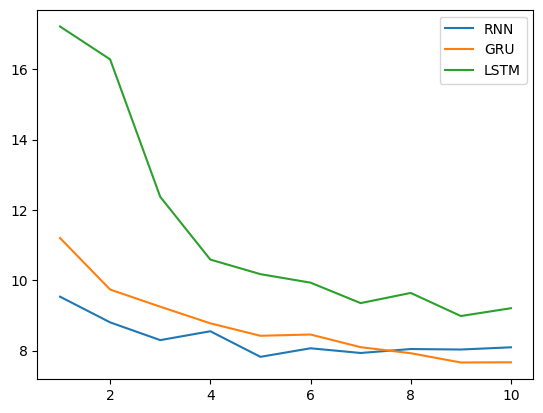

In [30]:
# Entrenamiento
sns.lineplot(x=range(1, len(history_ppl['RNN']) + 1), y=history_ppl['RNN'], label='RNN')
sns.lineplot(x=range(1, len(history_ppl['GRU']) + 1), y=history_ppl['GRU'], label='GRU')
sns.lineplot(x=range(1, len(history_ppl['LSTM']) + 1), y=history_ppl['LSTM'], label='LSTM')
plt.legend()
plt.show()

In [15]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_RNN = keras.models.load_model('my_modelRNN.keras')
model_GRU = keras.models.load_model('my_modelGRU.keras')
model_LSTM = keras.models.load_model('my_modelLSTM.keras')


### Predicción del próximo caracter

In [23]:
def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model_RNN.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [24]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

Probamos generando una secuencia que empiece con "the smartest " (el mas inteligente).

In [40]:
input_text='the first war '

print(generate_seq(model_RNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))

the first war and the dragonlords and the dr
the first war of the five gods. the city of 
the first war the cites of the fire the fith


Para redes relativamente sencillas como las que se implementaron, y para tiempos de entrenamiento relativamente cortos (10 epocas), podemos ver que la red mas elocuente es la RNN.

La simpleza de esta red permite obtener una respuesta aceptable con poco entrenamiento. Por otro lado, la red GRU muestra resultados un poco mejores que la LSTM, lo cual concuerda con la perplejidad medida durante el entrenamiento.

###  Beam search y muestreo aleatorio

In [26]:
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [27]:
# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

Probamos obtener secuencias por medio de beam search.

In [41]:
# predicción con beam search
salidasRNN = beam_search(model_RNN,num_beams=10,num_words=30,input="the dragonlords were ")
print(decode(salidasRNN[0]))

#salidasGRU = beam_search(model_GRU,num_beams=10,num_words=30,input="with the help of the ")
salidasGRU = beam_search(model_GRU,num_beams=10,num_words=30,input="the dragonlords were ")
print(decode(salidasGRU[0]))

#salidasLSTM = beam_search(model_LSTM,num_beams=10,num_words=30,input="sadly it was the defeat ")
salidasLSTM = beam_search(model_LSTM,num_beams=10,num_words=30,input="the dragonlords were ")
print(decode(salidasLSTM[0]))

the dragonlords were the lord of sydon and lutheria
the dragonlords were the dragonlords of the dragonl
the dragonlords were the great of thylea. the great


En este caso, sale a relucir mas la red LSTM. La red RNN da informacion erronea (los dragonlords son los enemigos de sydon y lutheria), lo que evidencia la falta de memoria que las otras redes tienen.

La red GRU rapidamente se estanca en un loop de "the dragonlords of" mientras que la LSTM consigue arrojar una oracion coherente y alusiva al texto original.